In [2]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

In [3]:
data_csv = pd.read_csv("data\\labeled_data.csv")
data_csv.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
tweets_list = data_csv['tweet'].tolist()
labels_list = data_csv['class'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [5]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [6]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [7]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [8]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [9]:
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

embedding_vecor_length = 200
class_count = Y.shape[1]

x = Input(shape=(max_wordNum,))
embedding_layer = Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train]
                       ,input_shape=(max_wordNum,),trainable=True,name='Embedding')(x)
reshape_layer = Reshape((max_wordNum , embedding_vecor_length , 1) , name='Reshape_Embedding')(embedding_layer)

one_gram_conv = Conv2D(200, kernel_size=(1, embedding_vecor_length), activation='relu' , use_bias=True
                       , name='1Gram_Conv')(reshape_layer)
one_gram_maxpool = MaxPooling2D(pool_size=(max_wordNum - 1 + 1, 1) 
                                , name='1Gram_Maxpool')(one_gram_conv)
one_gram_flatten = Flatten(name='1Gram_TimeDistributed_Flatten')(one_gram_maxpool)

two_gram_conv = Conv2D(200, kernel_size=(2, embedding_vecor_length), activation='relu' , use_bias=True 
                                , name='2Gram_Conv')(reshape_layer)
two_gram_maxpool = MaxPooling2D(pool_size=(max_wordNum - 2 + 1, 1) 
                                   , name='2Gram_Maxpool')(two_gram_conv)
two_gram_flatten = Flatten(name='2Gram_Flatten')(two_gram_maxpool)

three_gram_conv = Conv2D(200, kernel_size=(3, embedding_vecor_length), activation='relu' , use_bias=True 
                                  , name='3Gram_Conv')(reshape_layer)
three_gram_maxpool = MaxPooling2D(pool_size=(max_wordNum - 3 + 1, 1) 
                                , name='3Gram_Maxpool')(three_gram_conv)
three_gram_flatten = Flatten(name='3Gram_Flatten')(three_gram_maxpool)

merge = concatenate([one_gram_flatten, two_gram_flatten , three_gram_flatten] , name='Merge_n-grams')

fully_connected = Dense(20,activation='relu',name='Fully_Connected_Layer')(merge)

softmax_layer = Dense(class_count, activation='softmax', name='Softmax_Layer')(fully_connected)

output = softmax_layer
model = Model(inputs=x , outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 52, 200)      8607200     input_1[0][0]                    
__________________________________________________________________________________________________
Reshape_Embedding (Reshape)     (None, 52, 200, 1)   0           Embedding[0][0]                  
__________________________________________________________________________________________________
1Gram_Conv (Conv2D)             (None, 52, 1, 200)   40200       Reshape_Embedding[0][0]          
__________________________________________________________________________________________________
2Gram_Conv

In [10]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train,y_train,
                    validation_data=[X_valid,y_valid],
                    epochs=50, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 12397 samples, validate on 6190 samples
Epoch 1/50
12397/12397 [==============================] - 75s 6ms/step - loss: 0.3294 - acc: 0.8854 - val_loss: 0.2604 - val_acc: 0.9079
Epoch 2/50
12397/12397 [==============================] - 100s 8ms/step - loss: 0.2229 - acc: 0.9190 - val_loss: 0.2631 - val_acc: 0.9066
Epoch 3/50
12397/12397 [==============================] - 100s 8ms/step - loss: 0.1560 - acc: 0.9439 - val_loss: 0.2739 - val_acc: 0.9047
Epoch 4/50
12397/12397 [==============================] - 100s 8ms/step - loss: 0.0808 - acc: 0.9724 - val_loss: 0.3286 - val_acc: 0.8985
Epoch 5/50
12397/12397 [==============================] - 100s 8ms/step - loss: 0.0232 - acc: 0.9941 - val_loss: 0.3763 - val_acc: 0.8966
Epoch 6/50
12397/12397 [==============================] - 105s 8ms/step - loss: 0.0075 - acc: 0.9985 - val_loss: 0.4138 - val_acc: 0.8966
Epoch 00006: early stopping


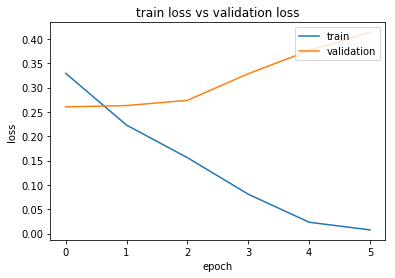

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [12]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4168043276926369
Test accuracy: 0.8997740477342772
